In [30]:
from AvDataloader import NeuraMatrixDataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import torch
import torchvision
from tqdm.notebook import tqdm
from torchvision import transforms
import torch.nn as nn
from torchmetrics import Accuracy
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt

In [2]:
Team_name="Name"

In [3]:
#Sample function to write Data Transformation 
def custum_transformation(image):
    im=np.array(image)
    transformations=A.Compose([
        A.Normalize(),
        ToTensorV2()]
    )
    return transformations(image=im)['image']

In [4]:
custum_trans=False #set to true if you are using other like Albumentations
if custum_trans:
    transform=custum_transformation
else:
    transform=transforms.Compose(
        [   
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406),std=(0.229, 0.224, 0.225))
        ]
    )

dataset=NeuraMatrixDataset(val_size=0.2,transform=transform)

 
            Data set for the event of this symposium Avinyaa 24 this uses the CIFAR-10 Dataset

            Which is loaded from the torchvision.datasets.CIFAR10 and with the random state.

            we further more split the training and testing size on to the user's Wish 

            and Data transformaions techniques could also been left to users to do

            or it is uses tensor and normalization on Imagenet weights by default

            The torch is prefered If you are using albumentations Write them as a seperate function
 
            and put them in the transform

Parameters:

            val_size: the size of the validation/dev set

            rand_state: custum random state default 42

Methods

            get_train_validation_dataset

            Returns 

            Training_data,testing_data

            
Files already downloaded and verified
Files already downloaded and verified


In [5]:
train,validation=dataset.get_train_validation_dataset()
test_dataset=dataset.get_test_dataset()

In [9]:
def iter_through_traindataset(dataset,model,device,Accuracy_fn,loss_fn,optimizer):
    running_loss=[]
    running_accuracy=[]
    model.train()
    for i in tqdm(dataset,total=len(dataset)):
        optimizer.zero_grad()
        image,label=i
        image=image.to(device)
        label=F.one_hot(label.long(),num_classes=10).float()
        y_pred=model(image)

        y_pred_labels=y_pred.argmax(dim=1)
        
        loss=loss_fn(y_pred,label)
        
        loss.backward()

        accuracy=Accuracy_fn(
            label.argmax(dim=1),
            y_pred_labels
        )

        optimizer.step()

        running_loss.append(loss.item())
        running_accuracy.append(accuracy.item())

    return np.mean(running_loss),np.mean(running_accuracy)        

In [10]:
def iter_through_valdataset(dataset,model,device,Accuracy_fn,loss_fn):
    with torch.no_grad():
        running_loss=[]
        running_accuracy=[]
        model.eval()
        for i in tqdm(dataset,total=len(dataset)):
            image,label=i
            image=image.to(device)
            label=F.one_hot(label.long(),num_classes=10).float()

            y_pred=model(image)

            y_pred_labels=y_pred.argmax(dim=1)
            loss=loss_fn(y_pred,label)

            accuracy=Accuracy_fn(
            label.argmax(dim=1),
            y_pred_labels
            )

            running_loss.append(loss.item())
            running_accuracy.append(accuracy.item())

        return np.mean(running_loss),np.mean(running_accuracy)

In [11]:
def training_model(model,loss_fn,device,accuracy_fn,train_data,val_data,epochs,lr=1e-3):
    history={
        
    }
    model=model.to(device)
    best_val=1000000.0
    optimizer=torch.optim.AdamW(model.parameters(),lr=lr)
    os.makedirs(f"Modelweights_{Team_name}")
    for epoch in range(epochs):
        print(f" Epoch: {epoch+1} \n")
        train_loss,train_acc=iter_through_traindataset(train_data,model,device,accuracy_fn,loss_fn,optimizer)
        
        if not 'train_loss' in history.keys():
            history['train_loss']=[train_loss]
        else:
            history['train_loss'].append(train_loss)
        
        if not 'train_acc' in history.keys():
            history['train_acc']=[train_acc]
        else:
            history['train_acc'].append(train_acc)

        val_loss,val_acc=iter_through_valdataset(val_data,model=model,device=device,Accuracy_fn=accuracy_fn,loss_fn=loss_fn)
        
        if not 'val_loss' in history.keys():
            history['val_loss']=[val_loss]
        else:
            history['val_loss'].append(val_loss)
        
        if not 'val_acc' in history.keys():
            history['val_acc']=[val_acc]
        else:
            history['val_acc'].append(val_acc)
        

        if val_loss < best_val: # type: ignore
            print("best validation loss is found")
            torch.save(model.state_dict(),"Modelweights/best_model.pth")


        print(f"""
                    train_loss {train_loss},
                    val_loss {val_loss},\n
                    train_acc {train_acc},
                    val_acc {val_acc}""")

In [19]:
def test_model(model,loss_fn,device,accuracy_fn,dataset,f1_score):
    with torch.no_grad():
        running_loss=[]
        running_accuracy=[]
        running_f1score=[]
        model=model.to(device)
        model.eval()
        for i in tqdm(dataset,total=len(dataset)):
            image,label=i
            image=image.to(device)
            label=F.one_hot(label.long(),num_classes=10).float()

            y_pred=model(image)

            y_pred_labels=y_pred.argmax(dim=1)
            loss=loss_fn(y_pred,label)

            accuracy=accuracy_fn(
            label.argmax(dim=1),
            y_pred_labels
            )
            f1=f1_score(
            label.argmax(dim=1),
            y_pred_labels 
            )

            running_loss.append(loss.item())
            running_accuracy.append(accuracy.item())

            running_f1score.append(f1.item())
        return np.mean(running_loss),np.mean(running_accuracy),np.mean(running_f1score)
    

In [13]:
class Neuramatrixmodel(nn.Module):
    def __init__(self,input=32):
        super().__init__()
        self.input=input
        self.net=nn.Sequential(
                nn.Linear(32*32*3,64),
                nn.Linear(64,32),
                nn.Linear(32,10)
            )
    def forward(self,x):
        x=x.view(-1,32*32*3)
        x=self.net(x)
        return x

In [14]:
from torchmetrics import F1Score


loss_fn=nn.CrossEntropyLoss()
acc_fn=Accuracy(task="multiclass",num_classes=10)
device=torch.device("cpu" if torch.cuda.is_available() else "cuda")
f1_score=F1Score(task="multiclass",num_classes=10)

In [15]:
model=Neuramatrixmodel()
model

Neuramatrixmodel(
  (net): Sequential(
    (0): Linear(in_features=3072, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=10, bias=True)
  )
)

In [17]:
training_model(model,loss_fn=loss_fn,accuracy_fn=acc_fn,train_data=t,val_data=v,lr=1e-4,device=device,epochs=3)

 Epoch: 1 



  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

best validation loss is found

                    train_loss 1.8664777216911317,
                    val_loss 1.7806838788925268,

                    train_acc 0.36065,
                    val_acc 0.3798921725239617
 Epoch: 2 



  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

best validation loss is found

                    train_loss 1.749252691078186,
                    val_loss 1.7195757955027084,

                    train_acc 0.402425,
                    val_acc 0.40884584664536744
 Epoch: 3 



  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

best validation loss is found

                    train_loss 1.7124650541305542,
                    val_loss 1.7183786512563786,

                    train_acc 0.41575,
                    val_acc 0.42342252396166136


In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [37]:
def give_results(model,loss_fn,f1_score,device,dataset,accuracy_fn):
    test_loss,test_acc,test_f1=test_model(model,loss_fn=loss_fn,f1_score=f1_score,device=device,dataset=dataset,accuracy_fn=accuracy_fn)
    total_labels=[]
    y_pred_labels=[]
    with torch.no_grad():
        for image, label in dataset:
            cu_l=label
            image=image.to(device)
            y_pred=model(image)
            y_pred_label=y_pred.argmax(dim=1)
            total_labels.extend(cu_l.tolist())
            y_pred_labels.extend(y_pred_label.tolist())
            print(y_pred_labels,cu_l)
    cm=confusion_matrix(y_true=total_labels,y_pred=y_pred_labels)
    plt.figure(figsize=(10,10))
    sns.heatmap(cm,annot=True)

    print(f" Test loss {test_loss}, Test acc {test_acc}, Test F1 {test_f1}")
    return test_loss, test_acc , test_f1

  0%|          | 0/313 [00:00<?, ?it/s]

[4, 2, 9, 6, 2, 6, 3, 6, 8, 0, 2, 5, 3, 8, 9, 3, 9, 2, 9, 5, 4, 9, 5, 0, 1, 8, 3, 3, 0, 7, 6, 3] tensor([4, 2, 3, 6, 2, 6, 6, 9, 8, 2, 2, 6, 3, 8, 1, 6, 8, 4, 9, 8, 2, 9, 3, 4,
        1, 1, 0, 3, 1, 9, 3, 5])
 Test loss 1.7694444919165713, Test acc 0.39237220447284343, Test F1 0.39237220447284343


(1.7694444919165713, 0.39237220447284343, 0.39237220447284343)

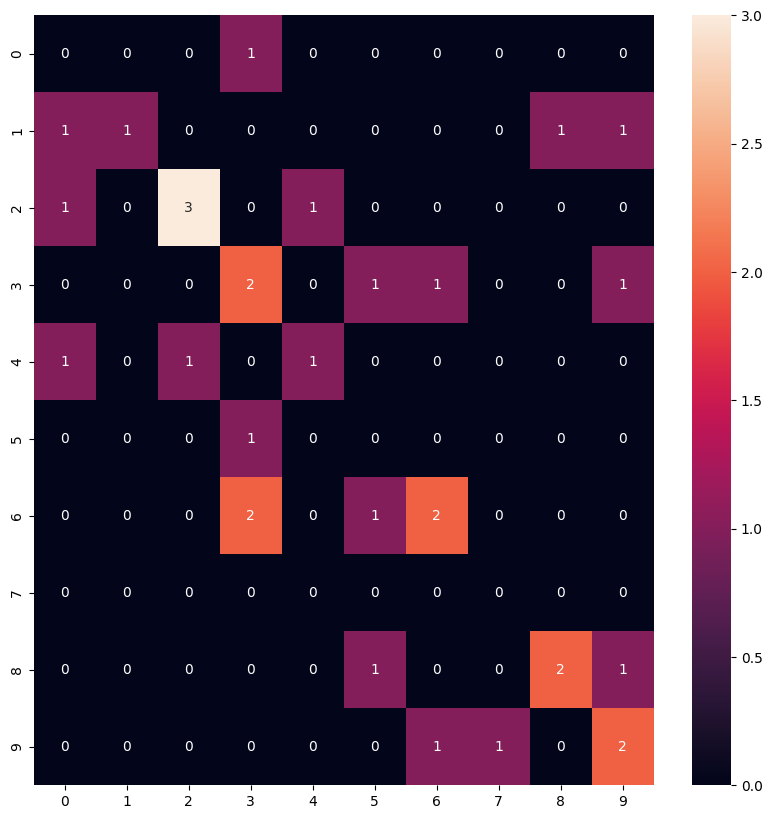

In [38]:
give_results(model,loss_fn,f1_score,device,test_dataset,acc_fn)

In [27]:
torch.randn(1,10).argmax(dim=1)

tensor([0])